<a href="https://colab.research.google.com/github/wesleybeckner/data_science_foundations/blob/main/notebooks/S4_Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Foundations, Session 4: Feature Engineering

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

---

<br>

In the previous session we talked about model pipelines and conveniently began with a suitable set of input data. In the real world, this is hardly ever the case! What is constant is this: at the end of the day, our models need numbers. Not only this, but a suitable set of numbers. What does that mean? The answer to that question is the subject of our session today.

<br>

---

<br>

<a name='top'></a>

<a name='2.0'></a>

## 4.0 Preparing Environment and Importing Data

[back to top](#top)

<a name='x.0.1'></a>

### 4.0.1 Import Packages

[back to top](#top)

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import random
import scipy.stats as stats
from scipy.stats import gamma
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns; sns.set()
from sklearn.datasets import load_iris
from sklearn.metrics import mean_squared_error, r2_score

<a name='x.0.2'></a>

### 4.0.2 Load Dataset

[back to top](#top)

In [2]:
margin = pd.read_csv('https://raw.githubusercontent.com/wesleybeckner/'\
        'ds_for_engineers/main/data/truffle_margin/truffle_margin_customer.csv')

orders = pd.read_csv('https://raw.githubusercontent.com/wesleybeckner/'\
                 'ds_for_engineers/main/data/truffle_margin/truffle_orders.csv')
time_cols = [i for i in orders.columns if '/' in i]

In [3]:
margin.head()

,Base Cake,Truffle Type,Primary Flavor,Secondary Flavor,Color Group,Customer,Date,KG,EBITDA/KG
0,Butter,Candy Outer,Butter Pecan,Toffee,Taupe,Slugworth,1/2020,53770.342593,0.500424
1,Butter,Candy Outer,Ginger Lime,Banana,Amethyst,Slugworth,1/2020,466477.578125,0.220395
2,Butter,Candy Outer,Ginger Lime,Banana,Burgundy,Perk-a-Cola,1/2020,80801.728070,0.171014
3,Butter,Candy Outer,Ginger Lime,Banana,White,Fickelgruber,1/2020,18046.111111,0.233025
4,Butter,Candy Outer,Ginger Lime,Rum,Amethyst,Fickelgruber,1/2020,19147.454268,0.480689


In [4]:
dfcat = margin.columns[:-2]
dfcat

Index(['Base Cake', 'Truffle Type', 'Primary Flavor', 'Secondary Flavor',
       'Color Group', 'Customer', 'Date'],
      dtype='object')

In [5]:
orders.head()

,Base Cake,Truffle Type,Primary Flavor,Secondary Flavor,Color Group,Customer,1/2020,2/2020,3/2020,4/2020,5/2020,6/2020,7/2020,8/2020,9/2020,10/2020,11/2020,12/2020
0,Butter,Candy Outer,Butter Pecan,Toffee,Taupe,Slugworth,53770.342593,40735.108025,40735.108025,40735.108025,53770.342593,40735.108025,40735.108025,40735.108025,53770.342593,40735.108025,40735.108025,40735.108025
1,Butter,Candy Outer,Ginger Lime,Banana,Amethyst,Slugworth,466477.578125,299024.088542,466477.578125,299024.088542,466477.578125,299024.088542,466477.578125,299024.088542,466477.578125,299024.088542,466477.578125,299024.088542
2,Butter,Candy Outer,Ginger Lime,Banana,Burgundy,Perk-a-Cola,80801.728070,51795.979532,51795.979532,51795.979532,80801.728070,51795.979532,51795.979532,51795.979532,80801.728070,51795.979532,51795.979532,51795.979532
3,Butter,Candy Outer,Ginger Lime,Banana,White,Fickelgruber,18046.111111,13671.296296,13671.296296,13671.296296,18046.111111,13671.296296,13671.296296,13671.296296,18046.111111,13671.296296,13671.296296,13671.296296
4,Butter,Candy Outer,Ginger Lime,Rum,Amethyst,Fickelgruber,19147.454268,12274.009146,12274.009146,12274.009146,12274.009146,12274.009146,19147.454268,12274.009146,12274.009146,12274.009146,12274.009146,12274.009146


<a name='2.1'></a>

## 4.1 Categorical Features

[back to top](#top)

At the end of the day, our algorithms operate on numerical values. How do you get from a series of string values to numerical values? 

In [6]:
margin['Customer'].unique()

array(['Slugworth', 'Perk-a-Cola', 'Fickelgruber', 'Zebrabar',
       "Dandy's Candies"], dtype=object)

A naive way to do it would be to assign a number to every entry
```
'Slugworth' = 1
'Perk-a-Cola' = 2
'Dandy's Candies' = 3
```
but we would inadvertently end up with some weird mathematical relationships between these variables, e.g. `Dandy's Candies - Perk-a-Cola = Slugworth` (3 - 2 = 1). 

A work around for this is to think *multi-dimensionally* we express our categorical values as vectors in a hyperspace where they cannot be expressed in terms of one another, i.e. they are *orthogonal* 
```
'Slugworth' = [1,0,0]
'Perk-a-Cola' = [0,1,0]
'Dandy's Candies' = [0,0,1]
```
such a scheme, in machine learning vernacular, is termed one-hot encoding. 

<a name='2.1.1'></a>

### 4.1.1 One-Hot Encoding

[back to top](#top)

sklearn has a couple useful libraries for one-hot encoding. let's start with the `OneHotEncoder` class in its `preprocessing` library

In [7]:
from sklearn.preprocessing import OneHotEncoder

In [8]:
# create the encoder object
enc = OneHotEncoder()

# grab the columns we want to convert from strings
X_cat = margin['Customer'].values.reshape(-1,1)

# fit our encoder to this data
enc.fit(X_cat)

OneHotEncoder()

After fitting our encoder, we can then use this object to create our training array.

In [9]:
# as a reference here's our original data
display(X_cat[:10])
print(X_cat.shape, end='\n\n')

onehotlabels = enc.transform(X_cat).toarray()
print(onehotlabels.shape, end='\n\n')

# And here is our new data
onehotlabels[:10]

array([['Slugworth'],
       ['Slugworth'],
       ['Perk-a-Cola'],
       ['Fickelgruber'],
       ['Fickelgruber'],
       ['Fickelgruber'],
       ['Slugworth'],
       ['Zebrabar'],
       ['Slugworth'],
       ['Zebrabar']], dtype=object)

(1668, 1)

(1668, 5)



array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

We have our customer information one-hot encoded, we need to do this for all our variables and concatenate them with our regular numerical variables in our original dataframe.

In [10]:
# create the encoder object
enc = OneHotEncoder()

# grab the columns we want to convert from strings
X_cat = margin[dfcat].values

# fit our encoder to this data
enc.fit(X_cat)
onehotlabels = enc.transform(X_cat).toarray()

In [11]:
X_num = margin["KG"]
print(X_num.shape)
X = np.concatenate((onehotlabels, X_num.values.reshape(-1,1)),axis=1)
X.shape

(1668,)


(1668, 119)

And now we grab our EBITDA (margin) data for prediction

In [14]:
y = margin["EBITDA/KG"]

#### 🏋️ Exercise 1: Create a simple linear model

Using the `X` and `y` sets, use `train_test_split` and `LinearRegression` to make a baseline model based on what we've learned so far.

Assess your model performance visually by plottying `y_test` vs `y_test_pred`

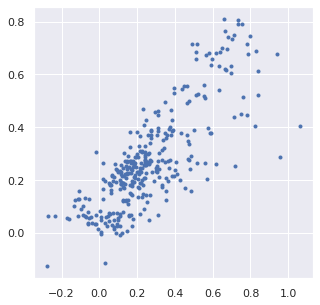

In [18]:
# Cell for Exercise 1
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


#### 🙋 Question 1:

> How can we assess the relative feature importance of the features in our model?

We could be tempted to inspect the coefficients (`linear.coef_`) of our  model to evaluate the relative feature importance, but in order to do this our features need to be scaled (so that the relative coefficient sizes are meaningful). What other issues might there be (think categorical vs continuous variables). 

<a name='2.2'></a>

## 4.2 Derived Features

[back to top](#top)

Can we recall an example of where we've seen this previously? That's right earlier on in our session on model selection and validation we derived some polynomial features to create our polynomial model using the linear regression class in sklearn. 

We actually see this a lot in engineering, where we will describe log relationships or some other transformation of the original variable. Actually let me see if I can find an example in my handy BSL...

<img src="https://raw.githubusercontent.com/wesleybeckner/ds_for_engineers/main/assets/C2/bird_stewart_lightfoot.jpg" width=500px></img>

<small>concentration profiles in continous stirred tank vs plug flow reactors. Notice the y-axis is log scale. Thanks Bird, Stewart, Lightfoot!</small>

> Can we think of other examples where we would like to derive features from our input data?

<a name='2.2.1'></a>

### 4.2.1 Creating Polynomials

[back to top](#top)

Let's revisit our example from the previous session, right before we introduced Grid Search in sklearn

In [19]:
# from Model Selection and Validation, 1.2.1
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

in the above, we use sklearn's convenient tool, `make_pipeline` to join together the preprocessing tool `PolynomialFeatures` and the basic model `LinearRegression`. Let's take a look at what PolynomialFeatures does to some simple data

In [20]:
x = np.arange(1,11)
y = x**3
print(x)
print(y)

[ 1  2  3  4  5  6  7  8  9 10]
[   1    8   27   64  125  216  343  512  729 1000]


In [22]:
features = PolynomialFeatures(degree=3)
X2 = features.fit_transform(x.reshape(-1,1))

we see our new feature set contains our original features, plus new features up to the nth-degree polynomial we set when creating the features object from `PolynomialFeatures`

In [23]:
print(X2)

[[   1.    1.    1.    1.]
 [   1.    2.    4.    8.]
 [   1.    3.    9.   27.]
 [   1.    4.   16.   64.]
 [   1.    5.   25.  125.]
 [   1.    6.   36.  216.]
 [   1.    7.   49.  343.]
 [   1.    8.   64.  512.]
 [   1.    9.   81.  729.]
 [   1.   10.  100. 1000.]]


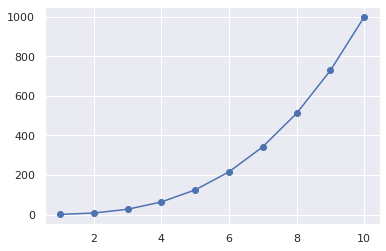

In [24]:
model = LinearRegression().fit(X2, y)
yhat = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, yhat);

<a name='2.2.2'></a>

### 4.2.2 Dealing with Time Series

[back to top](#top)

Often, we will be dealing with time series data, whether its data generated by machinery, reactors, or sales and customers. In the following we discuss some simple practices for dealing with time series data.

<a name='2.2.2.1'></a>

#### 🍒 4.2.2.1 **Enrichment**: Fast Fourier Transform

_Special thanks to [Brian Gerwe](https://github.com/BGerwe) for his contribution to this section_ 👨‍🍳

[back to top](#top)

Sometimes we'll want to create a more sophisticated transformation of our input data. As engineers, this can often have to do with some empirical knowledge we understand about our process.

When working with equipment and machinery, we will often want to convert a signal from the time to frequency domain. Let's cover how we can do that with numpy!

<img src="https://www.nti-audio.com/portals/0/pic/news/FFT-Time-Frequency-View-540.png" width=400px></img>

<small>[img src](https://www.nti-audio.com/en/support/know-how/fast-fourier-transform-fft)</small>

What I've drawn here in the following is called a [square-wave signal](https://en.wikipedia.org/wiki/Square_wave)

Text(0.5, 1.0, 'Frequency Domain')

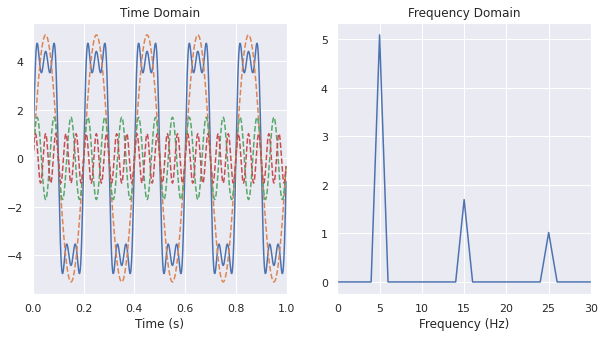

In [27]:
t = np.linspace(0,1,501)
# FFT should be given an integer number of cycles so we leave out last sample
t = t[:-1] 
f = 5 # linear frequency in Hz
w = f * 2 * np.pi # radial frequency
h = 4 # height of square wave
amp = 4 * h / np.pi
s = amp * (np.sin(w*t) + np.sin(3*w*t)/3 + np.sin(5*w*t)/5)

# here is the call to numpy FFT
F = np.fft.fft(s)
freq = np.fft.fftfreq(t.shape[-1], d=t[1])

# reorder frequency spectrum and frequency bins with 0 Hz at the center
F = np.fft.fftshift(F)
freq = np.fft.fftshift(freq)
# scale frequency spectrum to correct amplitude
F = F / t.size

# amplitudes
amps = [max(np.sin(w*t)), max(np.sin(w*t*3)/3), max(np.sin(w*t*5)/5)]

fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(t,s)
ax[0].plot(t,amp * np.sin(w*t), ls='--')
ax[0].plot(t,amp * np.sin(w*t*3)/3, ls='--')
ax[0].plot(t,amp * np.sin(w*t*5)/5, ls='--')
ax[0].set_title('Time Domain')
ax[0].set_xlim(0, 1)
ax[0].set_xlabel('Time (s)')

# tells us about the amplitude of the component at the
# corresponding frequency. Multiplied by two because the
# signal power is split between (-) and (+) frequency branches
# of FFT, but we're only visualizing the (+) branch
magnitude = 2 * np.sqrt(F.real**2 + F.imag**2)

ax[1].plot(freq, magnitude)
ax[1].set_xlim(0, 30)
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_title('Frequency Domain')

<a name='x.2.2.2'></a>

#### 4.2.2.2 Rolling Windows

[back to top](#top)

> to see an example of this dataset in action [visit this link](http://truffletopia.azurewebsites.net/forecast/)

One powerful technique for dealing with time series data, is to create a rolling window of features based on the historical data. The proper window size can usually be determined by trial and error, or constraints around access to the data itself.

<p align=center>
<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2019/11/3hotmk.gif"></img>
</p>

In the above gif, we have a window size of 7. What that means is for whatever time step units we are in (that could be minutes, days, months, etc.) we will have 7 of them included in a single instance or observation. This instance or observation is then interpreted by our model and used to assess the target value, typically the quantity in the very next time step after the window (the green bar in the gif).

Let's take an example with the orders data

In [52]:
tidy_orders = orders.melt(id_vars=orders.columns[:6], var_name='Date', value_name='KG')
display(tidy_orders.head())

,Base Cake,Truffle Type,Primary Flavor,Secondary Flavor,Color Group,Customer,Date,KG
0,Butter,Candy Outer,Butter Pecan,Toffee,Taupe,Slugworth,1/2020,53770.342593
1,Butter,Candy Outer,Ginger Lime,Banana,Amethyst,Slugworth,1/2020,466477.578125
2,Butter,Candy Outer,Ginger Lime,Banana,Burgundy,Perk-a-Cola,1/2020,80801.728070
3,Butter,Candy Outer,Ginger Lime,Banana,White,Fickelgruber,1/2020,18046.111111
4,Butter,Candy Outer,Ginger Lime,Rum,Amethyst,Fickelgruber,1/2020,19147.454268


In the next exercise, we are going to attempt to predict an order amount, based on the previous order history. We will scrub all categorical labels and only use historical amounts to inform our models. In effect the data that the model will see will look like the following:

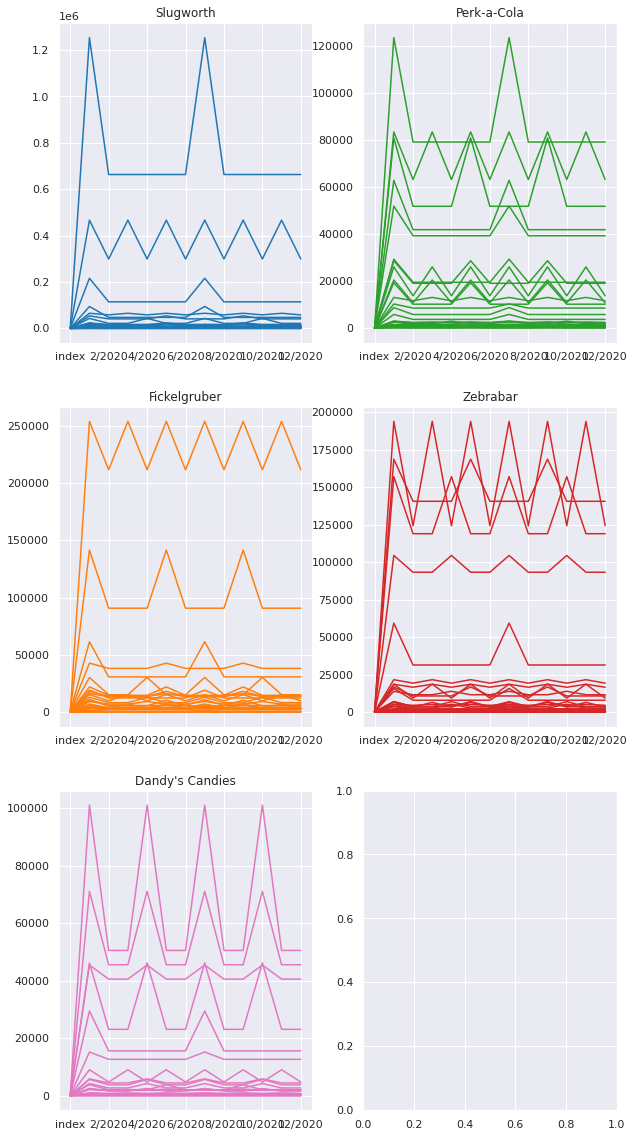

In [91]:
fig, ax = plt.subplots(3,2,figsize=(10,20))
indices = np.argwhere(ax)
color_dict = {0: 'tab:blue',
              1: 'tab:green',
              2: 'tab:orange',
              3: 'tab:red',
              4: 'tab:pink',
              5: 'tab:brown'}
for index, customer in enumerate(tidy_orders.Customer.unique()):
  orders.loc[orders.Customer == customer].iloc[:,6:].reset_index().T.plot(c=color_dict[index], legend=False,
                                                                          ax=ax[indices[index][0], indices[index][1]])
  ax[indices[index][0], indices[index][1]].set_title(customer)

What we may notice is that there is very little noise or drift in our order history, but there is certainly some periodicity. The question is can we use a linear model to predict the next order amount based on these history orders?

In [32]:
def process_data(Xy, time_cols=12, window=3, remove_null=False):
  """
  This function splits your time series data into the proper windows

  Parameters
  ----------
  Xy: array
    The input data. If there are non-time series columns, assumes they are on
    the left and time columns are on the right. 
  time_cols: int
    The number of time columns, default 12
  window: int
    The time window size, default 3

  Returns
  -------
  X_: array
    The independent variables, includes time and non-time series columns with
    the new window
  y_: array
    The dependent variable, selected from the time columns at the end of the 
    window
  labels:
    The time series labels, can be used in subsequent plot
  """
  # separate the non-time series columns
  X_cat = Xy[:,:-time_cols]

  # select the columns to apply the sweeping window
  X = Xy[:,-time_cols:]

  X_ = []
  y = []

  for i in range(X.shape[1]-window):
    # after attaching the current window to the non-time series 
    # columns, add it to a growing list
    X_.append(np.concatenate((X_cat, X[:, i:i+window]), axis=1))

    # add the next time delta after the window to the list of y
    # values
    y.append(X[:, i+window])

  # X_ is 3D: [number of replicates from sweeping window,
  #           length of input data, 
  #           size of new feature with categories and time]
  # we want to reshape X_ so that the replicates due to the sweeping window is 
  # a part of the same dimension as the instances of the input data
  X_ = np.array(X_).reshape(X.shape[0]*np.array(X_).shape[0],window+X_cat.shape[1])
  y = np.array(y).reshape(X.shape[0]*np.array(y).shape[0],)

  if remove_null:
    # remove training data where the target is 0 (may be unfair advantage)
    X_ = X_[np.where(~np.isnan(y.astype(float)))[0]]
    y = y[np.where(~np.isnan(y.astype(float)))[0]]

  # create labels that show the previous month values used to train the model
  labels = []
  for row in X_:
    labels.append("X: {}".format(np.array2string(row[-window:].astype(float).round())))
  return X_, y, labels

##### 🏋️ Exercise 2: Optimize Rolling Window Size for Customer Forecasts

For this exercise, you will use the `process_data` function below to help you optimize the `window` size for predicting the order quantity in any given month. You will train a `LinearRegression` model.

* create a model using a window size of 3 and predict the order quantity for the month immediately following the window
* create a model for window sizes 1-11 and report the \\(R^2\\) for each model

In [100]:
# Cell for Exercise 2
kg_month_data = orders.values[:,6:]

# use kg_month_data and the function process_data to create your X, y arrays
# then use train_test_split to create train and test portions
# USE y_test and  y_pred for your actual and true test data
# change only window parameter in process_data()
print("window   R2")
for window in range(1,12):
  ######################
  ### YOUR CODE HERE ###
  ######################
  pass

window   R2
1,	 0.97
2,	 0.88
3,	 0.80
4,	 0.96
5,	 0.90
6,	 0.86
7,	 0.61
8,	 0.89
9,	 0.76
10,	 0.74
11,	 0.87


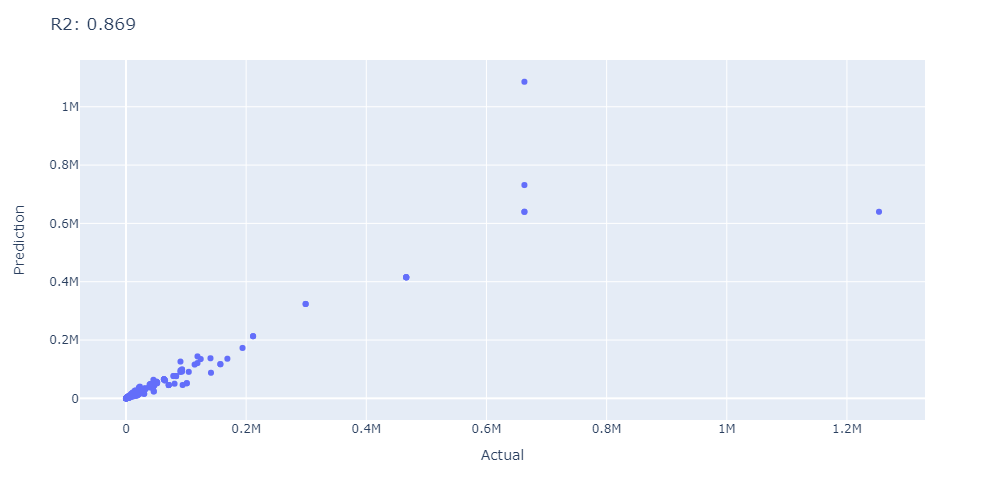

In [101]:
#### RUN AFTER EXERCISE 2.2.2.2.1 ####
fig = px.scatter(x=y_test, y=y_pred,
                 labels={
                     "y": "Prediction",
                     "x": "Actual"
                 })
fig.update_layout(
  autosize=False,
  width=800,
  height=500,
  title='R2: {:.3f}'.format(r2_score(y_test, y_pred))
  )

<a name='2.2.3'></a>

### 4.2.3 Image Preprocessing

[back to top](#top)

Image preprocessing is beyond the scope of this session. We cover this topic in [General Applications of Neural Networks](https://wesleybeckner.github.io/general_applications_of_neural_networks/S3_Computer_Vision_I/). For now, know that there is a wealth of considerations for how to handle images, and they all fit within the realm of feature engineering.

<a name='2.3'></a>

## 4.3 Transformed Features

[back to top](#top)

*Transformed* features, are features that we would like to augment based on their relationship within their own distribution or to other (allegedly) independent data within our training set. e.g. we're not *deriving* new features based on some empirical knowledge of the data, rather we are changing them due to statistical properties that we can assess based on the data itself.


<a name='2.3.1'></a>

### 4.3.1 Skewness

[back to top](#top)

<img src="https://i.pinimg.com/originals/d1/9f/7c/d19f7c7f5daaed737ab2516decea9874.png" width=400px></img>

Skewed data can lead to imbalances in our model prediction. Why? Skewed values in the distribution will bias the mean. When assigning weights to this input feature, therefore, the model will give preferential treatment to these values.

To demonstrate, I'm going to use scipy to create some skewed data.

In [102]:
from scipy.stats import skewnorm

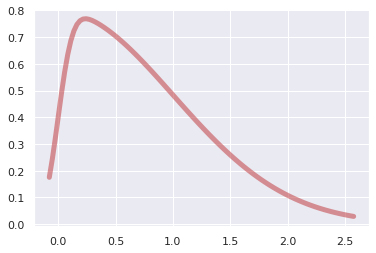

In [103]:
a = 10
x = np.linspace(skewnorm.ppf(0.01, a),
                skewnorm.ppf(0.99, a), 100)
plt.plot(x, skewnorm.pdf(x, a),
       'r-', lw=5, alpha=0.6, label='skewnorm pdf')

We can now generate a random population based on this distribution

(array([113., 267., 225., 172., 116.,  62.,  26.,  13.,   2.,   4.]),
 array([-0.19733964,  0.15303313,  0.50340589,  0.85377866,  1.20415142,
         1.55452419,  1.90489696,  2.25526972,  2.60564249,  2.95601526,
         3.30638802]),
 <BarContainer object of 10 artists>)

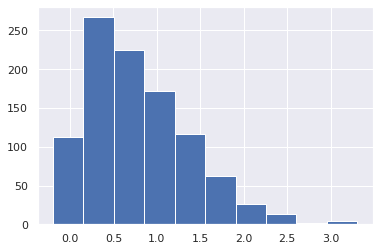

In [104]:
r = skewnorm.rvs(a, size=1000)
plt.hist(r)

Unskewed data will return something close to 0 from calling `df.skew()`. When dealing with actual data, we can use `df.skew()` to determine whether we should transform our data. 

In [105]:
x = pd.DataFrame(r, columns=['Skewed Data'])
x['Skewed Data'].skew()

0.9141902067398219

There are a handful of ways to deal with skewed data:

* log transform
* square root transform
* Box-Cox transform

Let's try the first two

square root transformed skew: 0.0561
log transformed skew: -1.6916


/home/wbeckner/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning:

invalid value encountered in sqrt

/home/wbeckner/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning:

invalid value encountered in log



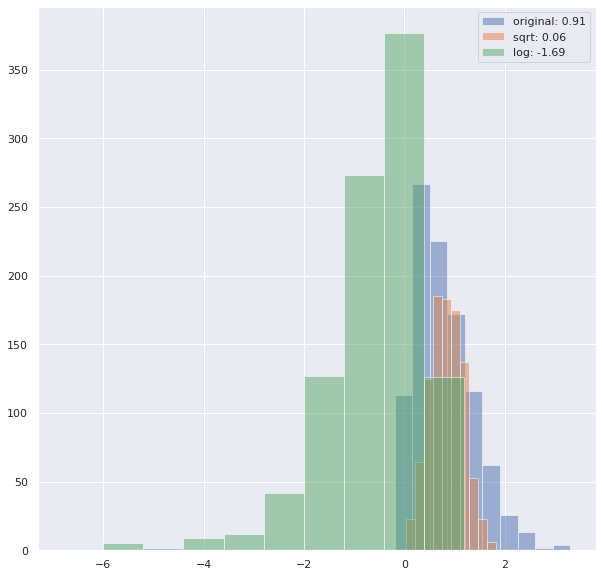

In [106]:
print('square root transformed skew: {:.4f}'.format(np.sqrt(x['Skewed Data']).skew()))
print('log transformed skew: {:.4f}'.format(np.log(x['Skewed Data']).skew()))
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.hist(x['Skewed Data'], alpha=0.5, label='original: {:.2f}'.
        format((x['Skewed Data']).skew()))
ax.hist(np.sqrt(x['Skewed Data']), alpha=0.5, label='sqrt: {:.2f}'.
        format(np.sqrt(x['Skewed Data']).skew()))
ax.hist(np.log(x['Skewed Data']), alpha=0.5, label='log: {:.2f}'.
        format(np.log(x['Skewed Data']).skew()))
ax.legend()

We see we didn't get much traction with the log transform, and the log transform will not be able to handle 0 values, and so we will sometimes have to code exceptions for those. 

Box-Cox is often a good route to go, but it has the added restriction that the data has to all be above 0.

Let's create a new distribution with this added restriction

(array([220., 277., 182., 127.,  66.,  39.,  17.,   5.,   4.,   2.]),
 array([2.17150536e-03, 3.88613862e-01, 7.75056219e-01, 1.16149858e+00,
        1.54794093e+00, 1.93438329e+00, 2.32082565e+00, 2.70726800e+00,
        3.09371036e+00, 3.48015272e+00, 3.86659507e+00]),
 <BarContainer object of 10 artists>)

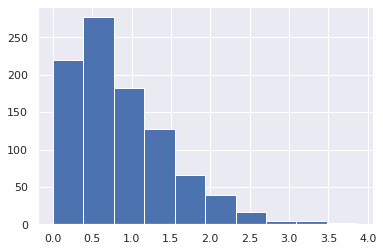

In [107]:
a = 6
r = skewnorm.rvs(a, size=1000)
r = [i for i in r if i > 0]
plt.hist(r)

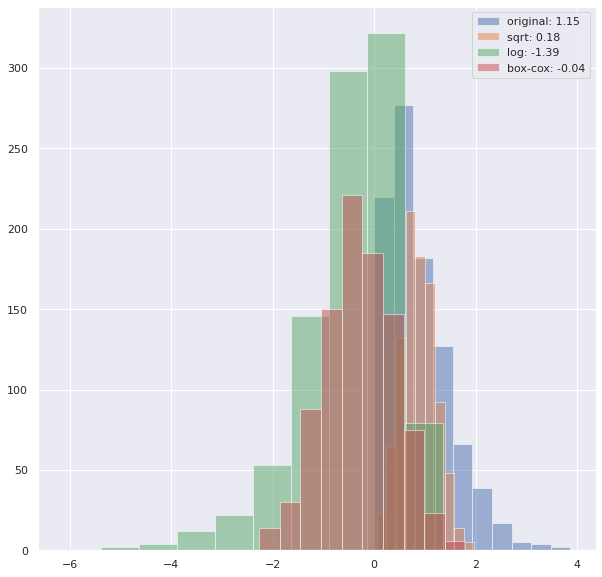

In [108]:
from scipy import stats

x = pd.DataFrame(r, columns=['Skewed Data'])
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.hist(x['Skewed Data'], alpha=0.5, label='original: {:.2f}'.
        format((x['Skewed Data']).skew()))
ax.hist(np.sqrt(x['Skewed Data']), alpha=0.5, label='sqrt: {:.2f}'.
        format(np.sqrt(x['Skewed Data']).skew()))
ax.hist(np.log(x['Skewed Data']), alpha=0.5, label='log: {:.2f}'.
        format(np.log(x['Skewed Data']).skew()))
ax.hist(stats.boxcox(x['Skewed Data'])[0], alpha=0.5, label='box-cox: {:.2f}'.
        format(pd.DataFrame(stats.boxcox(x['Skewed Data'])[0])[0].skew()))
ax.legend()


#### 🏋️ Exercise 3: Transform data from a gamma distribution

Repeat section 4.3.1, this time synthesizing a gamma distribution and transforming it. Which transformation best reduces the skew? Do this for a dataset that does not contain values at or below 0.

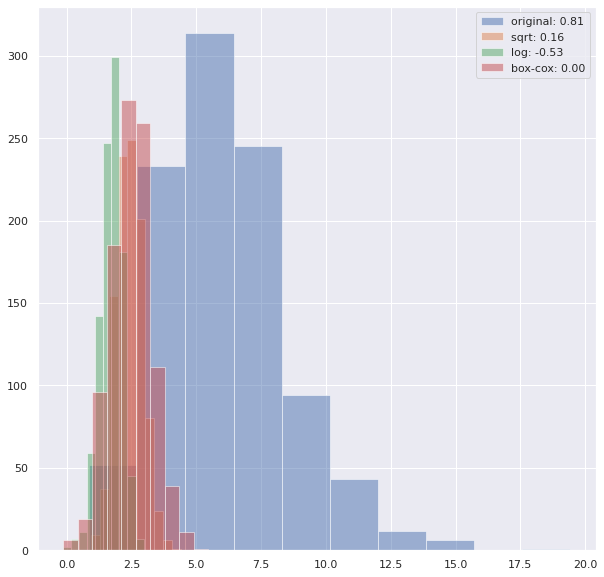

In [112]:
# Cell for exercise 3
from scipy.stats import gamma


<a name='2.3.2'></a>

### 4.3.2 Colinearity

[back to top](#top)

Colinearity can also affect the performance of your machine learning model. In particular, if features are colinear, it can be easy for your model to overfit to your training dataset. This is often mitigated by regularization. If you're curious you can read more about it on [this discussion from StackExchange](https://stats.stackexchange.com/questions/168622/why-is-multicollinearity-not-checked-in-modern-statistics-machine-learning). We will still explore it explicitly here by calculating the [Variance Inflation Factor](https://www.statsmodels.org/stable/_modules/statsmodels/stats/outliers_influence.html#variance_inflation_factor) (VIF) on some hypothetical data.

$$ VIF = \frac{1}{1-R^2}$$

Usually we are concerned about data with a VIF above 10



<a name='x.3.2.1'></a>

#### 4.3.2.1 Detecting Colinearity

[back to top](#top)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

**Step 1: Make some data**

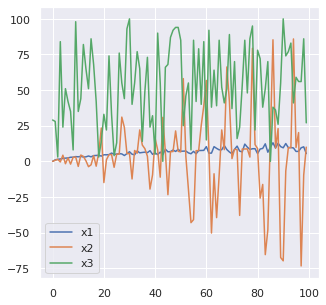

In [113]:
# we can throttle the error rate
random.seed(42)

# x2 will be sqrt of x1 plus some error
def func(x, err):
  return x**.5 + (err * random.randint(-1,1) * random.random() * x)
  
x0 = range(100)
x1 = [func(i, .05) for i in x0] # HIGH degree of colinearity with x0
x2 = [func(i, 1) for i in x0] # MED degree of colinearity with x0
x3 = [random.randint(0,100) for i in x0] # NO degree of colinearity with x0

# take a look
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.plot(x0, x1, label='x1')
ax.plot(x0, x2, label='x2')
ax.plot(x0, x3, label='x3')
ax.legend()

To calculate the colinearities I'm going to aggregate these x's into a dataframe:

In [114]:
colin = pd.DataFrame([x0,x1,x2,x3]).T
colin.columns = ['x0','x1','x2','x3']
colin.head()

,x0,x1,x2,x3
0,0.0,0.000000,0.000000,29.0
1,1.0,1.013751,0.721523,28.0
2,2.0,1.400260,1.414214,3.0
3,3.0,1.630546,-0.438007,84.0
4,4.0,2.017388,4.304847,24.0


**Step 2: Calculate VIF factors**

In [115]:
# calculate VIF factors
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(colin.values, i) for i in 
                     range(colin.shape[1])]
vif["features"] = colin.columns

**Step 3: Inspect VIF factors**

In [116]:
# inspect VIF factors
display(vif)

,VIF Factor,features
0,12.555415,x0
1,15.823872,x1
2,1.030609,x2
3,3.559468,x3


In this case, we may remove either `x0` or `x1` from the dataset.

<a name='x.3.2.2'></a>

#### 4.3.2.2 Fixing Colinearity

[back to top](#top)

It is good to aknowledge where colinearity exists as this will influence the interpretability of your model. In most cases, however, it won't have a heavy influence on the performance of your model. 

A simple method of dealing with colinearity, is to remove the highest VIF features from your model, iteratively, assessing the performance and determining whether to keep the variable or not. 

Another method is to create some linear combination of the correlated variables. This is encapsulated in the section on dimensionality reduction.

<a name='2.3.3'></a>

### 4.3.3 Normalization

[back to top](#top)

Many learning algorithms require zero mean and unit variance to behave optimally. Sklearn preprocessing library contains a very usefull class, `StandardScaler` for handling this automatically for us.


In [117]:
from sklearn.preprocessing import StandardScaler

In [118]:
scaler = StandardScaler()
normed = scaler.fit_transform(colin)

<AxesSubplot:ylabel='Density'>

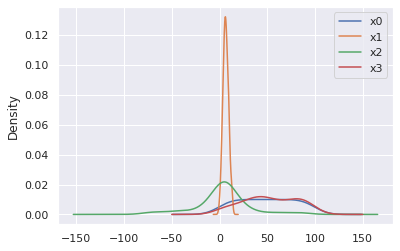

In [119]:
colin[['x0','x1','x2','x3']].plot(kind='kde')

<AxesSubplot:ylabel='Density'>

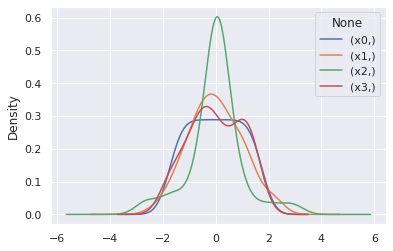

In [120]:
pd.DataFrame(normed, columns = [['x0','x1','x2','x3']]).plot(kind='kde')

#### 🏋️ Exercise 4: Normalization affect on VIF 

In the above, we saw how to scale and center variables. How does this affect VIF? 

* Calculate the VIF for the scaled-centered data

In [123]:
# Code Cell for Exercise 4


,VIF Factor,features
0,3.286048,x0
1,3.296881,x1
2,1.015805,x2
3,1.035537,x3


<a name='2.3.4'></a>

### 4.3.4 Dimensionality Reduction

[back to top](#top)

Dimensionality reduction is an awesome way to do feature engineering. It is very commonly used. Because it is also an unsupervised machine learning technique, we will visit this topic in that section.




<a name='2.4'></a>

## 4.4 Missing Data

[back to top](#top)

We will often have missing data in our datasets. How do we deal with this? Let's start by making some data with missing data. We'll use a numpy nan datatype to do this


In [124]:
from numpy import nan
X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   nan, 6  ],
              [ 8,   8,   1  ]])
y = np.array([14, 16, -1,  8, -5])

<a name='2.4.1'></a>

### 4.4.1 Imputation

[back to top](#top)

A very common strategy is to impute or fill in the missing data, based on basic statistical descriptions of the feature column (mode, mean, and median)



In [125]:
from sklearn.impute import SimpleImputer

# strategy = 'mean' will replace nan's with mean value
# of the column
# others are median and most_frequent (mode)
imp = SimpleImputer(strategy='mean')
X2 = imp.fit_transform(X)
X2

array([[4.5, 0. , 3. ],
       [3. , 7. , 9. ],
       [3. , 5. , 2. ],
       [4. , 5. , 6. ],
       [8. , 8. , 1. ]])

<a name='2.4.2'></a>

### 4.4.2 Other Strategies

[back to top](#top)

Depending on the severity of missing data, you will sometimes opt to remove the whole column, or perhaps apply some simple learning to fill in the missing data. This is a great [article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3668100/) on more advanced strategies for handling missing data.



# References

[back to top](#top)

* [Box Cox](https://www.statisticshowto.com/box-cox-transformation/)
* [Multicolinearity](https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/)
* [Missing Data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3668100/)